In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mc_frequentist.py
%run {helper_dir}/rollup_daily_logrets.py

In [4]:
class Quantile:
    def __init__(self, q):
        self.q = q
    def __call__(self, x):
        return np.quantile(x.dropna(), self.q)

## Input

In [5]:
chain = 'Avalanche'

In [6]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [7]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2022-01-06_2022-07-15.csv'}

## Prep Data

In [8]:
# read data
df = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                 index_col='Date', parse_dates=['Date'])
        .iloc[:-1, ] # drop the last row since it may not be a full day
        .loc[:, ['glpPrice', 'glpPlusFees']]
        .rename(columns={'glpPrice':'glp_price',
                         'glpPlusFees':'glp_plusfees_price',
                        })
     )
df.tail()

glp_price  glp_plusfees_price
Date                                     
2022-07-10     0.7151              0.8906
2022-07-11     0.6989              0.8746
2022-07-12     0.6877              0.8638
2022-07-13     0.7053              0.8820
2022-07-14     0.7178              0.8949

## Frequentist Monte Carlo Simulation of Future Returns of GLP

In [9]:
# input
future_days = 120 # how many days in the future (from the last day of observation) do you want to simulate?
n_sim = 1000      # how many times/paths do you want to run? (or the number of samples to draw for each future day)
start_date = df.index[0]     # investment start date, can use a date string, for example, '2022-06-15'

In [10]:
# calc historical daily log returns of GLP
logret_his = np.log(df.glp_plusfees_price / df.glp_plusfees_price.shift(1)).dropna()
logret_his.name = 'logret'
logret_his.index.name = 'date'

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 593.414] [loc=-0.001 scale=0.018]
[distfit] >[expon     ] [0.00 sec] [RSS: 5534.06] [loc=-0.068 scale=0.066]
[distfit] >[pareto    ] [0.05 sec] [RSS: 5739.51] [loc=-0.266 scale=0.198]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 463.367] [loc=-0.001 scale=0.014]
[distfit] >[t         ] [0.05 sec] [RSS: 366.637] [loc=-0.001 scale=0.014]
[distfit] >[genextreme] [0.12 sec] [RSS: 841.543] [loc=-0.008 scale=0.019]
[distfit] >[gamma     ] [0.07 sec] [RSS: 644.902] [loc=-0.367 scale=0.001]
[distfit] >[lognorm   ] [0.14 sec] [RSS: 597.852] [loc=-3.246 scale=3.245]
[distfit] >[beta      ] [0.10 sec] [RSS: 562.612] [loc=-174.140 scale=174.336]
[distfit] >[uniform   ] [0.00 sec] [RSS: 4190.75] [loc=-0.068 scale=0.131]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 552.408] [loc=-0.275 scale=0.087]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


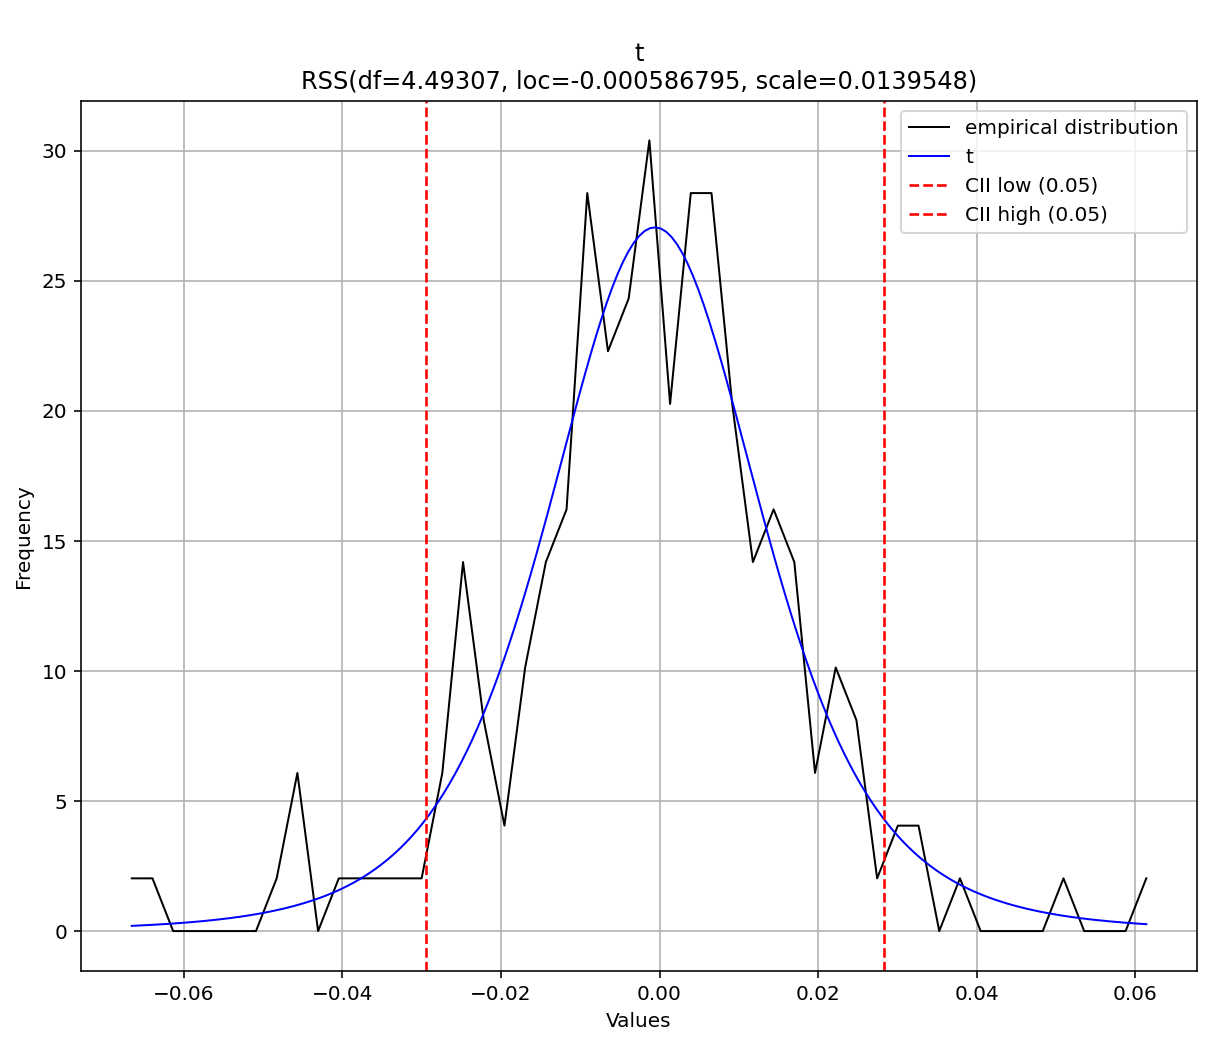

In [11]:
df_fut = mc_frequentist(logret_his, n_fut=future_days, n_iter=n_sim, show_plot=True)

In [12]:
# give meaning to the index of future log returns frame
df_fut.index = logret_his.index[-1] + pd.to_timedelta(df_fut.index.values+1, 'd')
df_fut.head()

iter1   iter2   iter3   iter4   iter5   iter6   iter7  ...  \
2022-07-15 0.0210 -0.0174  0.0186 -0.0163 -0.0112  0.0390  0.0240  ...   
2022-07-16 0.0194  0.0028 -0.0163  0.0243 -0.0238  0.0053  0.0015  ...   
2022-07-17 0.0067 -0.0002 -0.0058  0.0045 -0.0114 -0.0005 -0.0072  ...   
2022-07-18 0.0221 -0.0133 -0.0121 -0.0420 -0.0153  0.0080  0.0023  ...   
2022-07-19 0.0097  0.0022  0.0190 -0.0406 -0.0044  0.0018  0.0038  ...   

            iter994  iter995  iter996  iter997  iter998  iter999  iter1000  
2022-07-15   0.0081   0.0022  -0.0381  -0.0028   0.0104  -0.0203   -0.0007  
2022-07-16   0.0260  -0.0167   0.0185   0.0163  -0.0032  -0.0022    0.0162  
2022-07-17  -0.0097   0.0238  -0.0160  -0.0061  -0.0001  -0.0118    0.0012  
2022-07-18   0.0096   0.0046  -0.0089  -0.0172   0.0059  -0.0152    0.0210  
2022-07-19  -0.0264   0.0096  -0.0103  -0.0174   0.0049  -0.0178   -0.0025  

[5 rows x 1000 columns]

In [13]:
# change to long format
logret_fut = df_fut.stack()
# name the series and the levels of its index for ease of downstream process
logret_fut.name = logret_his.name
logret_fut.index.names = ['date', 'iter_no']
logret_fut

date        iter_no 
2022-07-15  iter1       0.0210
            iter2      -0.0174
            iter3       0.0186
            iter4      -0.0163
            iter5      -0.0112
                         ...  
2022-11-11  iter996    -0.0040
            iter997     0.0487
            iter998     0.0185
            iter999    -0.0204
            iter1000   -0.0002
Name: logret, Length: 120000, dtype: float64

In [14]:
# give multilevel index to logret_his to be consistent with logret_fut and because
# rollup_daily_logrets() downstream expects such a multilevel index.
# since there are no runs of simulation for historical data, we'll simply use 'iter0' for the `iter_no` level.
new_index = list(zip(logret_his.index, ['iter0']*len(logret_his)))
logret_his.index = pd.MultiIndex.from_tuples(new_index, names=(logret_his.index.name, 'iter_no'))
logret_his

date        iter_no
2022-01-07  iter0     -0.0120
2022-01-08  iter0     -0.0082
2022-01-09  iter0      0.0102
2022-01-10  iter0     -0.0356
2022-01-11  iter0      0.0295
                        ...  
2022-07-10  iter0     -0.0117
2022-07-11  iter0     -0.0181
2022-07-12  iter0     -0.0124
2022-07-13  iter0      0.0208
2022-07-14  iter0      0.0145
Name: logret, Length: 189, dtype: float64

In [15]:
last_day = logret_his.index.get_level_values('date')[-1]
assert pd.to_datetime(start_date) <= last_day # can't start after the last day of available historical returns

# select historical daily log returns after investment start data
print("Investment started on", start_date, '\n')
chosen_logret_his = logret_his.loc[pd.to_datetime(start_date) + pd.Timedelta(days=1):]
print(chosen_logret_his.head())

Investment started on 2022-01-06 00:00:00 

date        iter_no
2022-01-07  iter0     -0.0120
2022-01-08  iter0     -0.0082
2022-01-09  iter0      0.0102
2022-01-10  iter0     -0.0356
2022-01-11  iter0      0.0295
Name: logret, dtype: float64


In [16]:
# roll up to weekly and monthly levels
dd_his = rollup_daily_logrets(chosen_logret_his)
dd_fut = rollup_daily_logrets(logret_fut)

## The Growth Paths of $10,000 in GLP

In [17]:
# user inputs
init_investment = 10_000 # dollars
time_freq = 'daily' # 'daily', 'weekly', or 'monthly'

In [18]:
# choose data based on user input
logrets_his = dd_his[time_freq]
logrets_fut = dd_fut[time_freq]

if time_freq == 'daily':
    time_freq_col = 'date'
elif time_freq == 'weekly':
    time_freq_col = 'week'    
else: # runs monthly by default
    time_freq_col = 'month'

In [19]:
# calc value of investment at each past time index
values_his = init_investment * logrets_his.cumsum().apply(np.exp)
values_his.name = 'value'
values_his = values_his.to_frame()
values_his

value
iter_no date                 
iter0   2022-01-07 9,880.5222
        2022-01-08 9,800.2435
        2022-01-09 9,900.5484
        2022-01-10 9,554.6256
        2022-01-11 9,840.3269
...                       ...
        2022-07-10 7,605.0734
        2022-07-11 7,468.7343
        2022-07-12 7,376.7380
        2022-07-13 7,531.6261
        2022-07-14 7,641.7253

[189 rows x 1 columns]

In [20]:
# calc value of investment at each future time index
value_now = values_his.value[-1]
values_fut = (
    logrets_fut.reset_index()
        .rename(columns={'level_0':'iter_no'})
        .set_index(['iter_no', time_freq_col])
        .sort_index()
        .groupby('iter_no')
        .logret.cumsum().apply(np.exp)
    ) * value_now
values_fut.name = 'value'
values_fut = values_fut.to_frame()
values_fut

value
iter_no date                 
iter1   2022-07-15 7,804.1192
        2022-07-16 7,956.8270
        2022-07-17 8,010.5576
        2022-07-18 8,189.1625
        2022-07-19 8,269.2553
...                       ...
iter999 2022-11-07 7,024.2696
        2022-11-08 7,002.1560
        2022-11-09 7,092.3171
        2022-11-10 7,126.3252
        2022-11-11 6,982.6844

[120000 rows x 1 columns]

In [21]:
# create a row of data for initial investment 
time_delta_val = pd.Timedelta(days=1) if time_freq == 'daily' else 1 
t0 = values_his.index.get_level_values(time_freq_col)[0] - time_delta_val 
# print(t0)
idx = pd.MultiIndex.from_arrays([['iter0'], [t0]], names=('iter_no', time_freq_col)) 
value_genesis = pd.DataFrame({'value': init_investment}, index=idx)
value_genesis

value
iter_no date             
iter0   2022-01-06  10000

In [22]:
# stack 
value_growth_paths = pd.concat([value_genesis, values_his, values_fut]) 
value_growth_paths

value
iter_no date                  
iter0   2022-01-06 10,000.0000
        2022-01-07  9,880.5222
        2022-01-08  9,800.2435
        2022-01-09  9,900.5484
        2022-01-10  9,554.6256
...                        ...
iter999 2022-11-07  7,024.2696
        2022-11-08  7,002.1560
        2022-11-09  7,092.3171
        2022-11-10  7,126.3252
        2022-11-11  6,982.6844

[120190 rows x 1 columns]

In [23]:
# reformat and prep for plot
value_growth_paths = value_growth_paths.reset_index()
value_growth_paths['group'] = np.where(value_growth_paths.iter_no == 'iter0', 'historical', 'predicted')
value_growth_paths.head()

iter_no       date       value       group
0   iter0 2022-01-06 10,000.0000  historical
1   iter0 2022-01-07  9,880.5222  historical
2   iter0 2022-01-08  9,800.2435  historical
3   iter0 2022-01-09  9,900.5484  historical
4   iter0 2022-01-10  9,554.6256  historical

In [24]:
# calc the mean and 95% CI of investment value at each time
value_means_cis = (value_growth_paths.query("iter_no != 'iter0'") # iter0 iff historical
                       .groupby(time_freq_col)
                       .agg(value_m = ('value', np.mean),
                            value_l = ('value', Quantile(.025)),
                            value_u = ('value', Quantile(.975)))
                  ).reset_index()
value_means_cis

date    value_m    value_l     value_u
0   2022-07-15 7,639.7780 7,373.1769  7,941.7319
1   2022-07-16 7,641.2640 7,233.9795  8,042.0348
2   2022-07-17 7,633.0084 7,137.6009  8,125.5949
3   2022-07-18 7,632.4317 7,079.2425  8,190.1243
4   2022-07-19 7,624.5112 7,016.1533  8,270.8346
..         ...        ...        ...         ...
115 2022-11-07 7,311.3912 4,824.0275 10,562.2585
116 2022-11-08 7,316.1402 4,790.1558 10,566.6237
117 2022-11-09 7,313.9062 4,772.2268 10,566.9922
118 2022-11-10 7,318.5384 4,834.8517 10,664.7298
119 2022-11-11 7,316.2997 4,790.2009 10,605.1149

[120 rows x 4 columns]

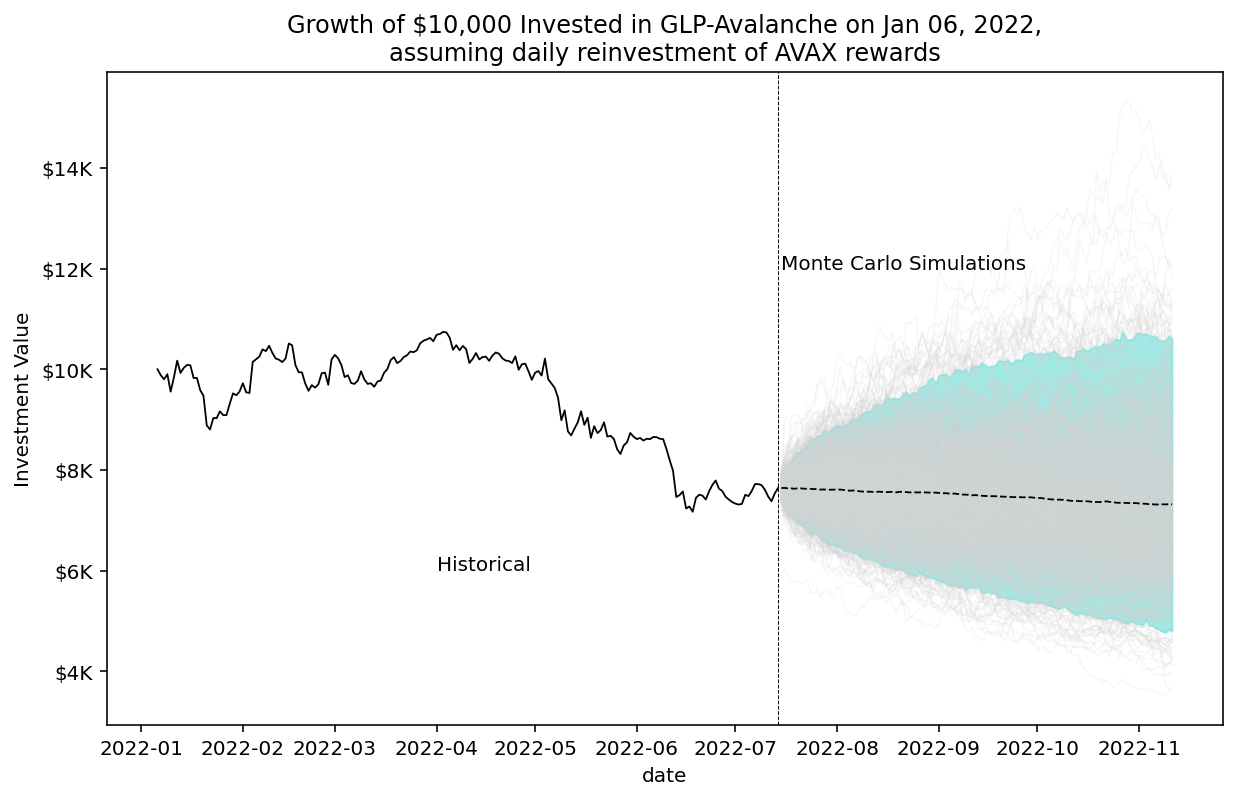

In [25]:
fig, ax = plt.subplots(1, 1)
plt.title("Growth of ${:,} Invested in GLP-{} on {},\nassuming daily reinvestment of {} rewards".format(init_investment, chain, start_date.strftime('%b %d, %Y'), reward_token))
plt.xlabel(time_freq_col)
plt.ylabel("Investment Value")

# plot historical value path
value_growth_his = value_growth_paths.query("iter_no=='iter0'")
plt.plot(time_freq_col, 'value', data=value_growth_his, color='black', alpha=1, linewidth=0.9)

# add a verticle line at the last day of historical observations; from this point onward (to the right), it's all forecasts
plt.axvline(x=last_day, linewidth=0.5, color='black', linestyle='--')

# add simulated paths for the future
for i in range(1, n_sim+1):
    da = value_growth_paths[value_growth_paths.iter_no == 'iter{}'.format(i)]
    plt.plot(time_freq_col, 'value', data=da, color='lightgray', alpha=0.2, linewidth=0.7)

# add the mean path of those simulated future paths
plt.plot(time_freq_col, 'value_m', data=value_means_cis, color='black', alpha=1, linewidth=0.9, linestyle='--')

# add the 95% confidence band of those simulated future paths
plt.fill_between(time_freq_col, y1='value_u', y2='value_l', data=value_means_cis, 
                 color="#4aeae044", linewidth=0.9, alpha=0.6)

# format y-axis to dollar currency
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

# add text
plt.text(pd.to_datetime('2022-04-01'), 6000, 'Historical')
plt.text(pd.to_datetime('2022-07-15'), 12000, 'Monte Carlo Simulations')

# save
fname = 'glp_investment_growth_since_{}_mc_vanilla.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);

## Some statistics on the simulated future returns

In [26]:
# calculate cumulative returns for each iteration
cumu_rets_fut = np.exp(logrets_fut.groupby('iter_no').cumsum()) - 1
cumu_rets_fut.name = 'cumu_ret'
cumu_rets_fut.head()

iter_no  date      
iter1    2022-07-15   0.0213
         2022-07-16   0.0412
         2022-07-17   0.0483
         2022-07-18   0.0716
         2022-07-19   0.0821
Name: cumu_ret, dtype: float64

In [27]:
# only analyze cummulative returns in x days, where x is defined as
x_days = [7, 30, 60, 90, 120] # days
fut_start_date = cumu_rets_fut.index.get_level_values('date').min()
fut_end_dates = [fut_start_date + pd.Timedelta(days=d-1) for d in x_days]
chosen_cumu_rets_fut = cumu_rets_fut.loc[(slice(None), fut_end_dates)]
chosen_cumu_rets_fut.head() 

iter_no  date      
iter1    2022-07-21    0.0948
         2022-08-13    0.0872
         2022-09-12    0.0789
         2022-10-12   -0.0341
         2022-11-11    0.0391
Name: cumu_ret, dtype: float64

In [28]:
newindex = ['in {} days'.format(d) for d in x_days]

In [29]:
# calc expected return percentiles         
ret_percentiles = (chosen_cumu_rets_fut
                       .groupby('date')
                       .agg(percentile_10th = Quantile(.1),
                            percentile_25th = Quantile(.25),
                            percentile_50th = Quantile(.5),
                            percentile_75th = Quantile(.75),
                            percentile_90th = Quantile(.9),)
                  )
ret_percentiles.index = newindex
ret_percentiles = ret_percentiles.style.format('{:.2%}'.format)
dfi.export(ret_percentiles, os.path.join(png_dir, chain, 'glp_simret_percentiles.png'))
ret_percentiles

[0715/105627.028314:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmp3enqvrri/temp.png.


In [30]:
# calc return probabilities 
target_rets = np.array([0, 10, 25, 50, 100]) / 100
ret_probs = pd.concat((chosen_cumu_rets_fut.groupby('date').apply(lambda x: 1 - ECDF(x)(target_ret)) for target_ret in target_rets), axis=1)
ret_probs.index = newindex
ret_probs.columns = ["Return > {:.0%}".format(r) for r in target_rets]
ret_probs = ret_probs.style.format('{:.2%}'.format)
dfi.export(ret_probs, os.path.join(png_dir, chain, 'glp_simret_probs.png'))
ret_probs

[0715/105628.419505:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmp87kqg9fl/temp.png.
